In [1]:
import os
import string
import re
from pathlib import Path

In [5]:
current_dir = Path(os.getcwd()).absolute()
results_dir = current_dir.joinpath('results')
results_dir.mkdir(parents=True, exist_ok=True)
data_dir = current_dir.joinpath('data')
data_dir.mkdir(parents=True, exist_ok=True)
external_data_dir = current_dir.parent.parent.parent.joinpath('data')
imdb_dir = external_data_dir.joinpath(r'external/imdb/aclImdb')




print(current_dir)
print(results_dir)
print(data_dir)
print(imdb_dir)

/home/jovyan/dsc650/dsc650/assignments/assignment10
/home/jovyan/dsc650/dsc650/assignments/assignment10/results
/home/jovyan/dsc650/dsc650/assignments/assignment10/data
/home/jovyan/dsc650/data/external/imdb/aclImdb


#### Assignment 10.1.a  

Create a tokenize function that splits a sentence into words. Ensure that your tokenizer removes basic punctuation.

In [32]:
file_name = "sample.txt"
file_path = f"{data_dir}\{file_name}"
file_path

'c:\\Users\\saman\\git_repos\\dsc650\\dsc650\\assignments\\assignment10\\data\\sample.txt'

In [ ]:
def tokenize(sentence):
    tokens = []
    words = sentence.split()
    # tokenize the sentence
    for word in words:
        # allowing only alphabets
        word = re.sub("[^a-zA-Z]", "", word)
        tokens.append(word)
    return tokens

In [ ]:
def call_tokenize():
	with open(f'{file_path}','r') as f:
		for line in f:
			line = line.lower()
			# print(line, end = 'XX')
			return tokenize(line)

call_tokenize()

#### Assignment 10.1.b

Implement an `ngram` function that splits tokens into N-grams. 

In [ ]:
def ngram(tokens, n):
    # ngrams = []
    # Create ngrams
    # return ngrams
    return print(list(zip(*[tokens[i:] for i in range(n)])))

In [ ]:
def call_ngram():
	with open(f'{file_path}','r') as f:
		for line in f:
			line = line.lower()
			# print(line, end = 'XX')
			return ngram(tokenize(line),3)

call_ngram()

#### Assignment 10.1.c

Implement an one_hot_encode function to create a vector from a numerical vector from a list of tokens.

In [ ]:
def one_hot_encode(tokens, num_words):
    token_index = {}
    results = ''
    return results

#### 10.2

Using listings 6.16, 6.17, and 6.18 in Deep Learning with Python as a guide, train a sequential model with embeddings on the IMDB data found in data/external/imdb/. Produce the model performance metrics and training and validation accuracy curves within the Jupyter notebook.

In [6]:
# Processing the labels of the raw IMDB data
train_dir = imdb_dir.joinpath('train')
labels = []
texts = []

for label_type in ['neg','pos']:
	dir_name = train_dir.joinpath(label_type) 
	for fname in os.listdir(dir_name):
		if fname[-4:] == '.txt':
			f = open(dir_name.joinpath(fname))
			texts.append(f.read())
			f.close()
			if label_type == 'neg':
				labels.append(0)
			else:
				labels.append(1)

In [9]:
# Tokenizing the text of the raw IMDB data

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# cuts off reviews after 100 words
maxlen = 100
# trains 200 samples
training_samples = 200
#validates on 10,000 samples
validation_samples = 10000
# considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a validation set, but first shuffles the data,
# because you’re starting with data in which samples are ordered (all negative first, then all positive)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [15]:
# Parsing the GloVe word-embeddings file
glove_dir = '/home/jovyan/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# Preparing the GloVe word-embeddings matrix

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
# Training the same model without pretrained word embeddings
# Model Definition

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Found 400000 word vectors.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Training and Evaluating the model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))


Epoch 1/10
7/7 [==============================] - 1s 148ms/step - loss: 0.6977 - acc: 0.4550 - val_loss: 0.6931 - val_acc: 0.5039
Epoch 2/10
7/7 [==============================] - 1s 110ms/step - loss: 0.5253 - acc: 1.0000 - val_loss: 0.6979 - val_acc: 0.5091
Epoch 3/10
7/7 [==============================] - 1s 112ms/step - loss: 0.3170 - acc: 1.0000 - val_loss: 0.7010 - val_acc: 0.5084
Epoch 4/10
7/7 [==============================] - 1s 116ms/step - loss: 0.1435 - acc: 1.0000 - val_loss: 0.7018 - val_acc: 0.5143
Epoch 5/10
7/7 [==============================] - 1s 112ms/step - loss: 0.0665 - acc: 1.0000 - val_loss: 0.7087 - val_acc: 0.5141
Epoch 6/10
7/7 [==============================] - 1s 112ms/step - loss: 0.0329 - acc: 1.0000 - val_loss: 0.7134 - val_acc: 0.5221
Epoch 7/10
7/7 [==============================] - 1s 110ms/step - loss: 0.0187 - acc: 1.0000 - val_loss: 0.7188 - val_acc: 0.5157
Epoch 8/10
7/7 [==============================] - 1s 107ms/step - loss: 0.0104 - acc: 1.00

In [17]:
#saving the model
model.save_weights('glove_model.h5')

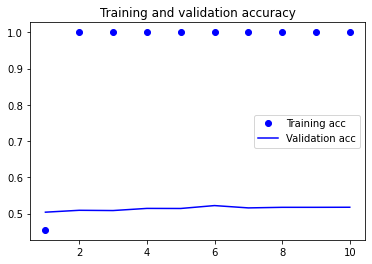

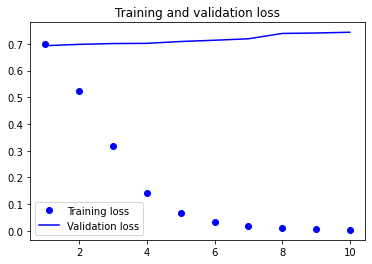

In [18]:
# Plotting the results from the training and validation set

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
# Tokenizing the data for the test set
test_dir = imdb_dir.joinpath('test')
labels = []
texts = []

for label_type in ['neg','pos']:
	dir_name = test_dir.joinpath(label_type) 
	for fname in os.listdir(dir_name):
		if fname[-4:] == '.txt':
			f = open(dir_name.joinpath(fname))
			texts.append(f.read())
			f.close()
			if label_type == 'neg':
				labels.append(0)
			else:
				labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)
print('Shape of data tensor:', x_test.shape)
print('Shape of label tensor:', y_test.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [20]:
# Load and evaluate the model on the test set
model.load_weights('glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.7396 - acc: 0.5303


[0.7395750880241394, 0.5302799940109253]

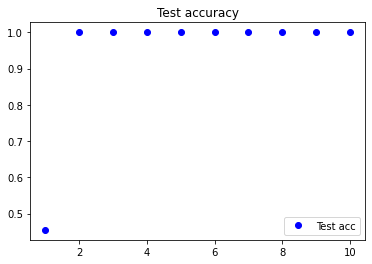

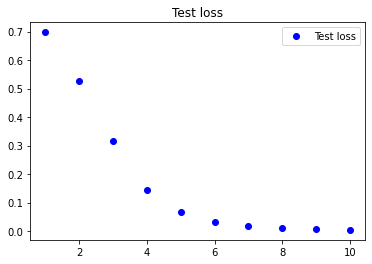

In [21]:
# Plotting the results from the test set

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Test acc')
plt.title('Test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Test loss')
plt.title('Test loss')
plt.legend()
plt.show()